In [1]:
import numpy as np
from skimage import filters, color, transform
import matplotlib.pyplot as plt

In [2]:
def compute_energy(image):
    grad_x = filters.sobel_h(image)  # Gradient in x-direction
    grad_y = filters.sobel_v(image)  # Gradient in y-direction
    
    # Absolute values of gradients
    abs_grad_x = np.abs(grad_x)
    abs_grad_y = np.abs(grad_y)
    
    energy = abs_grad_x + abs_grad_y    # Energy map is the sum of absolute gradients
    return energy

In [3]:
def find_vertical_seam(energy):
    rows, cols = energy.shape

    cumulative_energy = np.copy(energy)     # Initialize the energy map
    
    # Fill the [energy map] Using DP
    for i in range(1, rows):
        for j in range(cols):
            # Handle edge cases for the first and last columns
            left = cumulative_energy[i-1, j-1] if j > 0 else float('inf')
            middle = cumulative_energy[i-1, j]
            right = cumulative_energy[i-1, j+1] if j < cols-1 else float('inf')
            
            # Update cumulative energy
            cumulative_energy[i, j] += min(left, middle, right)
    
    # Backtrack to find the seam
    seam = []
    j = np.argmin(cumulative_energy[-1])  # Start from the bottom row
    for i in range(rows-1, -1, -1):
        seam.append((i, j))
        if i == 0:
            break
        # Update j to the best neighbor in the previous row
        left = j-1 if j > 0 else j
        right = j+1 if j < cols-1 else j
        j = left + np.argmin(cumulative_energy[i-1, left:right+1])  # **
    
    # Reverse the seam to start from the top
    seam.reverse()
    return seam

In [4]:
def find_horizontal_seam(energy):
    rows, cols = energy.shape
    cumulative_energy = np.copy(energy)    # Initialize the cumulative energy map
    
    # Fill the cumulative energy map using DP
    for j in range(1, cols):
        for i in range(rows):
            # Handle edge cases for the first and last rows
            top = cumulative_energy[i-1, j-1] if i > 0 else float('inf')
            middle = cumulative_energy[i, j-1]
            bottom = cumulative_energy[i+1, j-1] if i < rows-1 else float('inf')
            
    cumulative_energy[i, j] += min(top, middle, bottom)     # Update cumulative energy
            
    # Backtrack to find the seam
    seam = []
    i = np.argmin(cumulative_energy[:, -1])  # Start from the rightmost column
    for j in range(cols-1, -1, -1):
        seam.append((i, j))
        if j == 0:
            break
        # Update i to the best neighbor in the previous column
        top = i-1 if i > 0 else i
        bottom = i+1 if i < rows-1 else i
        i = top + np.argmin(cumulative_energy[top:bottom+1, j-1])
    
    # Reverse the seam to start from the left
    seam.reverse()
    return seam

In [5]:
def remove_vertical_seam(image, seam):
    rows, cols, _ = image.shape
    mask = np.ones((rows, cols), dtype=bool)    # Create a mask for the seam
    
    for (i, j) in seam:
        mask[i, j] = False
    
    # Remove the seam by shifting pixels
    new_image = np.zeros((rows, cols-1, 3), dtype=np.uint8)
    for i in range(rows):
        new_image[i, :] = image[i, mask[i, :]]
    
    return new_image

In [6]:
def remove_horizontal_seam(image, seam):
    rows, cols, _ = image.shape
    mask = np.ones((rows, cols), dtype=bool)    # Create a mask for the seam
    
    for (i, j) in seam:
        mask[i, j] = False
    
    # Remove the seam by shifting pixels
    new_image = np.zeros((rows-1, cols, 3), dtype=np.uint8)
    for j in range(cols):
        new_image[:, j] = image[mask[:, j], j]
    
    return new_image

In [7]:
def visualize_seam(image, seam):
    image_with_seam = np.copy(image)
    for (i, j) in seam:
        image_with_seam[i, j] = [255, 0, 0]  # Highlight seam in red
    return image_with_seam

In [8]:
def seam_carving(image, new_width, new_height):
    gray = color.rgb2gray(image)         # Convert image to grayscale as it's suffiecent for the energy computation process and works faster
    image_with_seams = np.copy(image)    # Create a copy of the original image to visualize seams
    
    # Resize horizontally by removing vertical seams
    while image.shape[1] > new_width:
        energy = compute_energy(gray)
        seam = find_vertical_seam(energy)
        image = remove_vertical_seam(image, seam)
        gray = color.rgb2gray(image)  # Update grayscale image
        
        for (i, j) in seam: # Visualize the seam on the original image
            image_with_seams[i, j] = [255, 0, 0]  # Highlight seam in red

    # Resize vertically by removing horizontal seams
    while image.shape[0] > new_height:
        energy = compute_energy(gray)
        seam = find_horizontal_seam(energy)
        image = remove_horizontal_seam(image, seam)
        gray = color.rgb2gray(image)  # Update grayscale image
    
        for (i, j) in seam:     # Visualize the seam on the original image
            image_with_seams[i, j] = [255, 0, 0]  # Highlight seam in red
            
    return image, image_with_seams

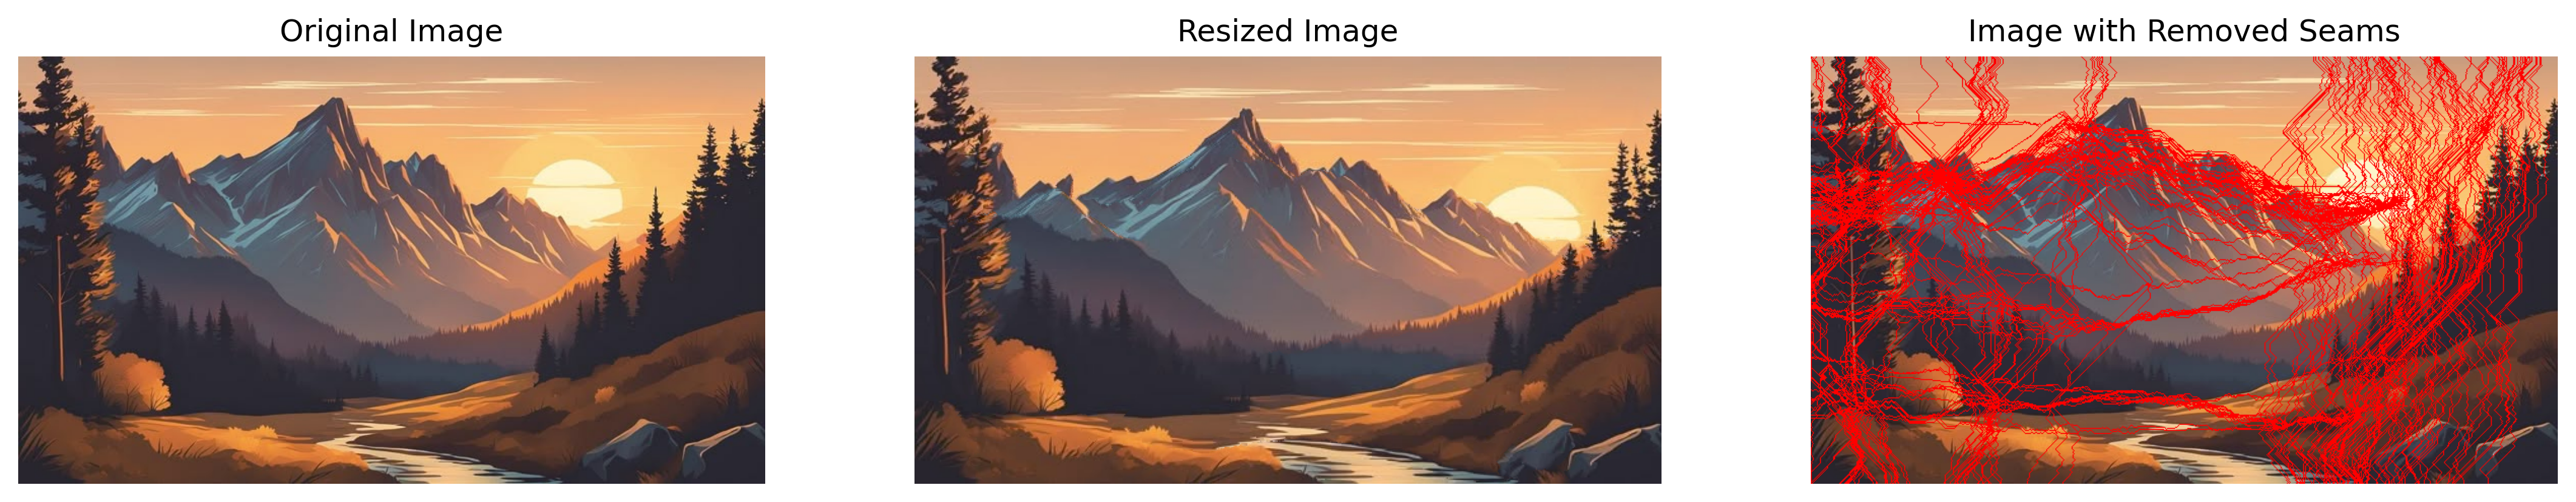

In [12]:
# Load the image using matplotlib
image = plt.imread("Input.jpeg")

# Resize the image using seam carving
α, β = 0.8, 0.8
new_width = image.shape[1] * (α)    # Reduce width by (α)
new_height = image.shape[0] * (β)   # Reduce height by (β)
resized_image, image_with_seams = seam_carving(image, new_width, new_height)

# Save the resized image and the image with seams
plt.imsave(f"resized_image [{α}, {β}].jpg", resized_image)
plt.imsave(f"image_with_seams [{α}, {β}].jpg", image_with_seams)

# Display the Original image
plt.figure(figsize=(18, 12), dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Display the resized image 
plt.subplot(1, 3, 2)
plt.imshow(resized_image)
plt.title("Resized Image")
plt.axis('off')

# Display the image with seams
plt.subplot(1, 3, 3)
plt.imshow(image_with_seams)
plt.title("Image with Removed Seams") 
plt.axis('off')

plt.show()